# Fornax 2024 Demo Plots

Plot spectra from the Fornax 2024 models by
* *The Gravitational-Wave Signature of Core-Collapse Supernovae* by David Vartanyan, Adam Burrows, Tianshu Wang, Matthew S.B. Coleman, and Christopher White [Phys. Rev. D 107:103015, 2023](https://doi.org/10.1103/PhysRevD.107.103015).
* *Physical Correlations and Predictions Emerging from Modern Core-collapse Supernova Theory* by Adam Burrows, Tianshu Wang, and David Vartanyan, [Astrophys.  J. Lett. 964:16, 2024](https://doi.org/10.3847/2041-8213/ad319e).
* *Gravitational-wave and Gravitational-wave Memory Signatures of Core-collapse Supernovae* by Lyla Choi, Adam Burrows, and David Vartanyan, [Astrophys. J.  975:12, 2024](https://doi.org/10.3847/1538-4357/ad74f8).

In [1]:
from read_spec import read_spec, Spectrum
from astropy import units as u
from astropy.table import Table

In [2]:
import os
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
mpl.rc('font', size=14)

## Generator demo

This shows how to loop through a given spectrum file and extract a `Spectrum` object.

In [4]:
for (t, E, F) in read_spec('18/nuspec.0.xg'):
    sp = Spectrum(t, E, F)
    if sp.t == 10*u.ms:
        print(sp)
        break

        0.01 s
    1.208765 MeV      0.608521 MeV   2.57953e+49 erg / (MeV s)
    1.944325 MeV      0.978819 MeV   1.64302e+50 erg / (MeV s)
    3.127487 MeV      1.574451 MeV   1.26927e+51 erg / (MeV s)
    5.030630 MeV      2.532538 MeV   1.01686e+52 erg / (MeV s)
    8.091874 MeV      4.073641 MeV   3.99083e+52 erg / (MeV s)
   13.015950 MeV      6.552538 MeV   8.41382e+52 erg / (MeV s)
   20.936430 MeV     10.539895 MeV   5.36886e+52 erg / (MeV s)
   33.676693 MeV     16.953644 MeV    1.1653e+52 erg / (MeV s)
   54.169670 MeV     27.270295 MeV   1.49674e+50 erg / (MeV s)
   87.133057 MeV     43.864846 MeV   2.36557e+46 erg / (MeV s)
  140.155365 MeV     70.557531 MeV    4.9219e+39 erg / (MeV s)
  225.442871 MeV    113.493280 MeV   1.55869e+39 erg / (MeV s)



## Plot Spectra between 0 s and 2 s

Loop through the spectra and plot a selection of times between 0 s and 2 s.

In [5]:
def plot_spectra(filename):
    times = np.arange(-0.1, 2, 0.2) * u.s
    colors = plt.cm.magma(np.linspace(0,1,len(times)))
    
    fig, ax = plt.subplots(1,1, figsize=(8,5))

    for (t, E, F) in read_spec(filename):
        sp = Spectrum(t, E, F)
        i = np.where(np.abs(times - sp.t) < 0.5*u.ms)[0]
        if i.size:
            i = i[0]
        else:
            continue

        p = ax.plot(sp.E, sp.F, color=colors[i], alpha=0.7, label=f'{sp.t:.1f}')
        ax.errorbar(sp.E, sp.F, xerr=sp.dE/2, fmt='o', capsize=2, color=p[0].get_color(), alpha=0.4)
        ax.set(yscale='log',
               ylabel='flux [erg MeV$^{-1}$ s$^{-1}$]',
               ylim=(1e40, 1e53),
               xlabel='energy [MeV]')

    ax.legend(fontsize=8, loc='best', ncol=3)
    return fig

## $\nu_e$ spectra

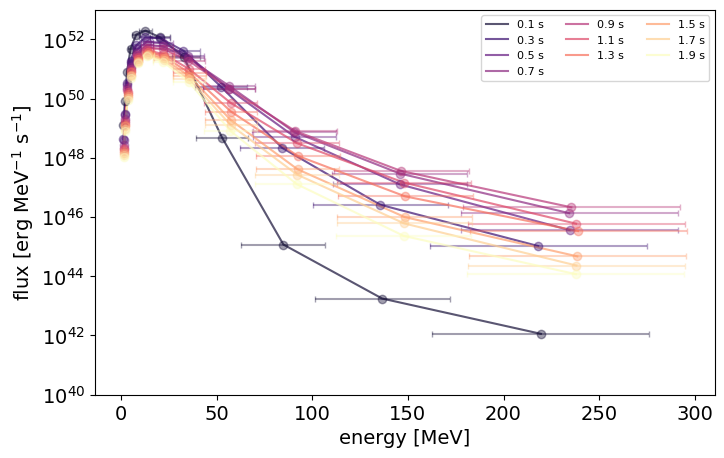

In [6]:
fig = plot_spectra('18/nuspec.0.xg')

## $\bar{\nu}_e$ spectra

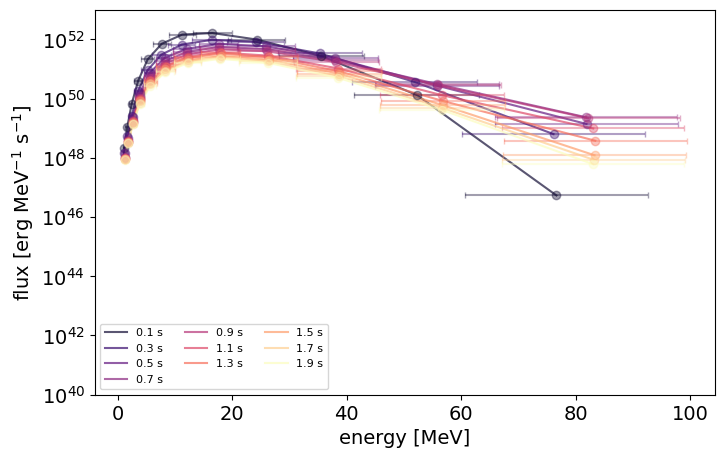

In [7]:
fig = plot_spectra('18/nuspec.1.xg')

## $\nu_x$ spectra

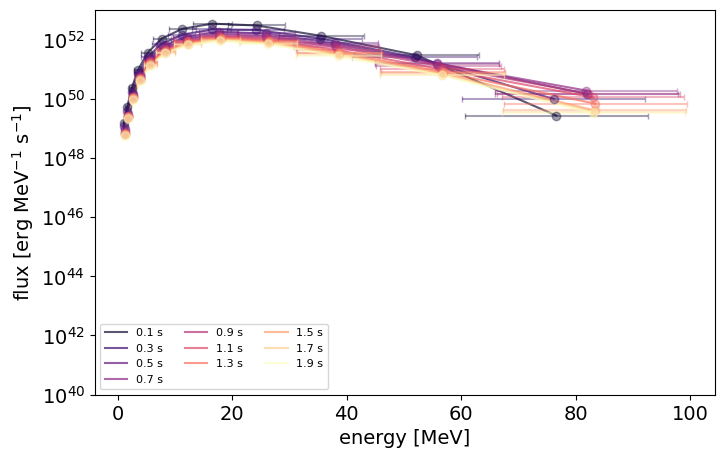

In [8]:
fig = plot_spectra('18/nuspec.2.xg')

## Plot the Angle-averaged Luminosity

Using the `nustat` files, plot the luminosity $L_{\nu}(t)$.

In [9]:
#- Get list of folders in this directory, pick out the models and progenitor masses
modelnames = [name for name in os.listdir('.') if os.path.isdir(os.path.join('.', name)) and ''.join(filter(str.isdigit, name)) != '']
models = {}
for model in modelnames:
    mass = float(re.sub('[a-z]', '', model))
    if mass in models:
        if not model in models[mass]:
            models[mass].append(model)
    else:
        models[mass] = [model]

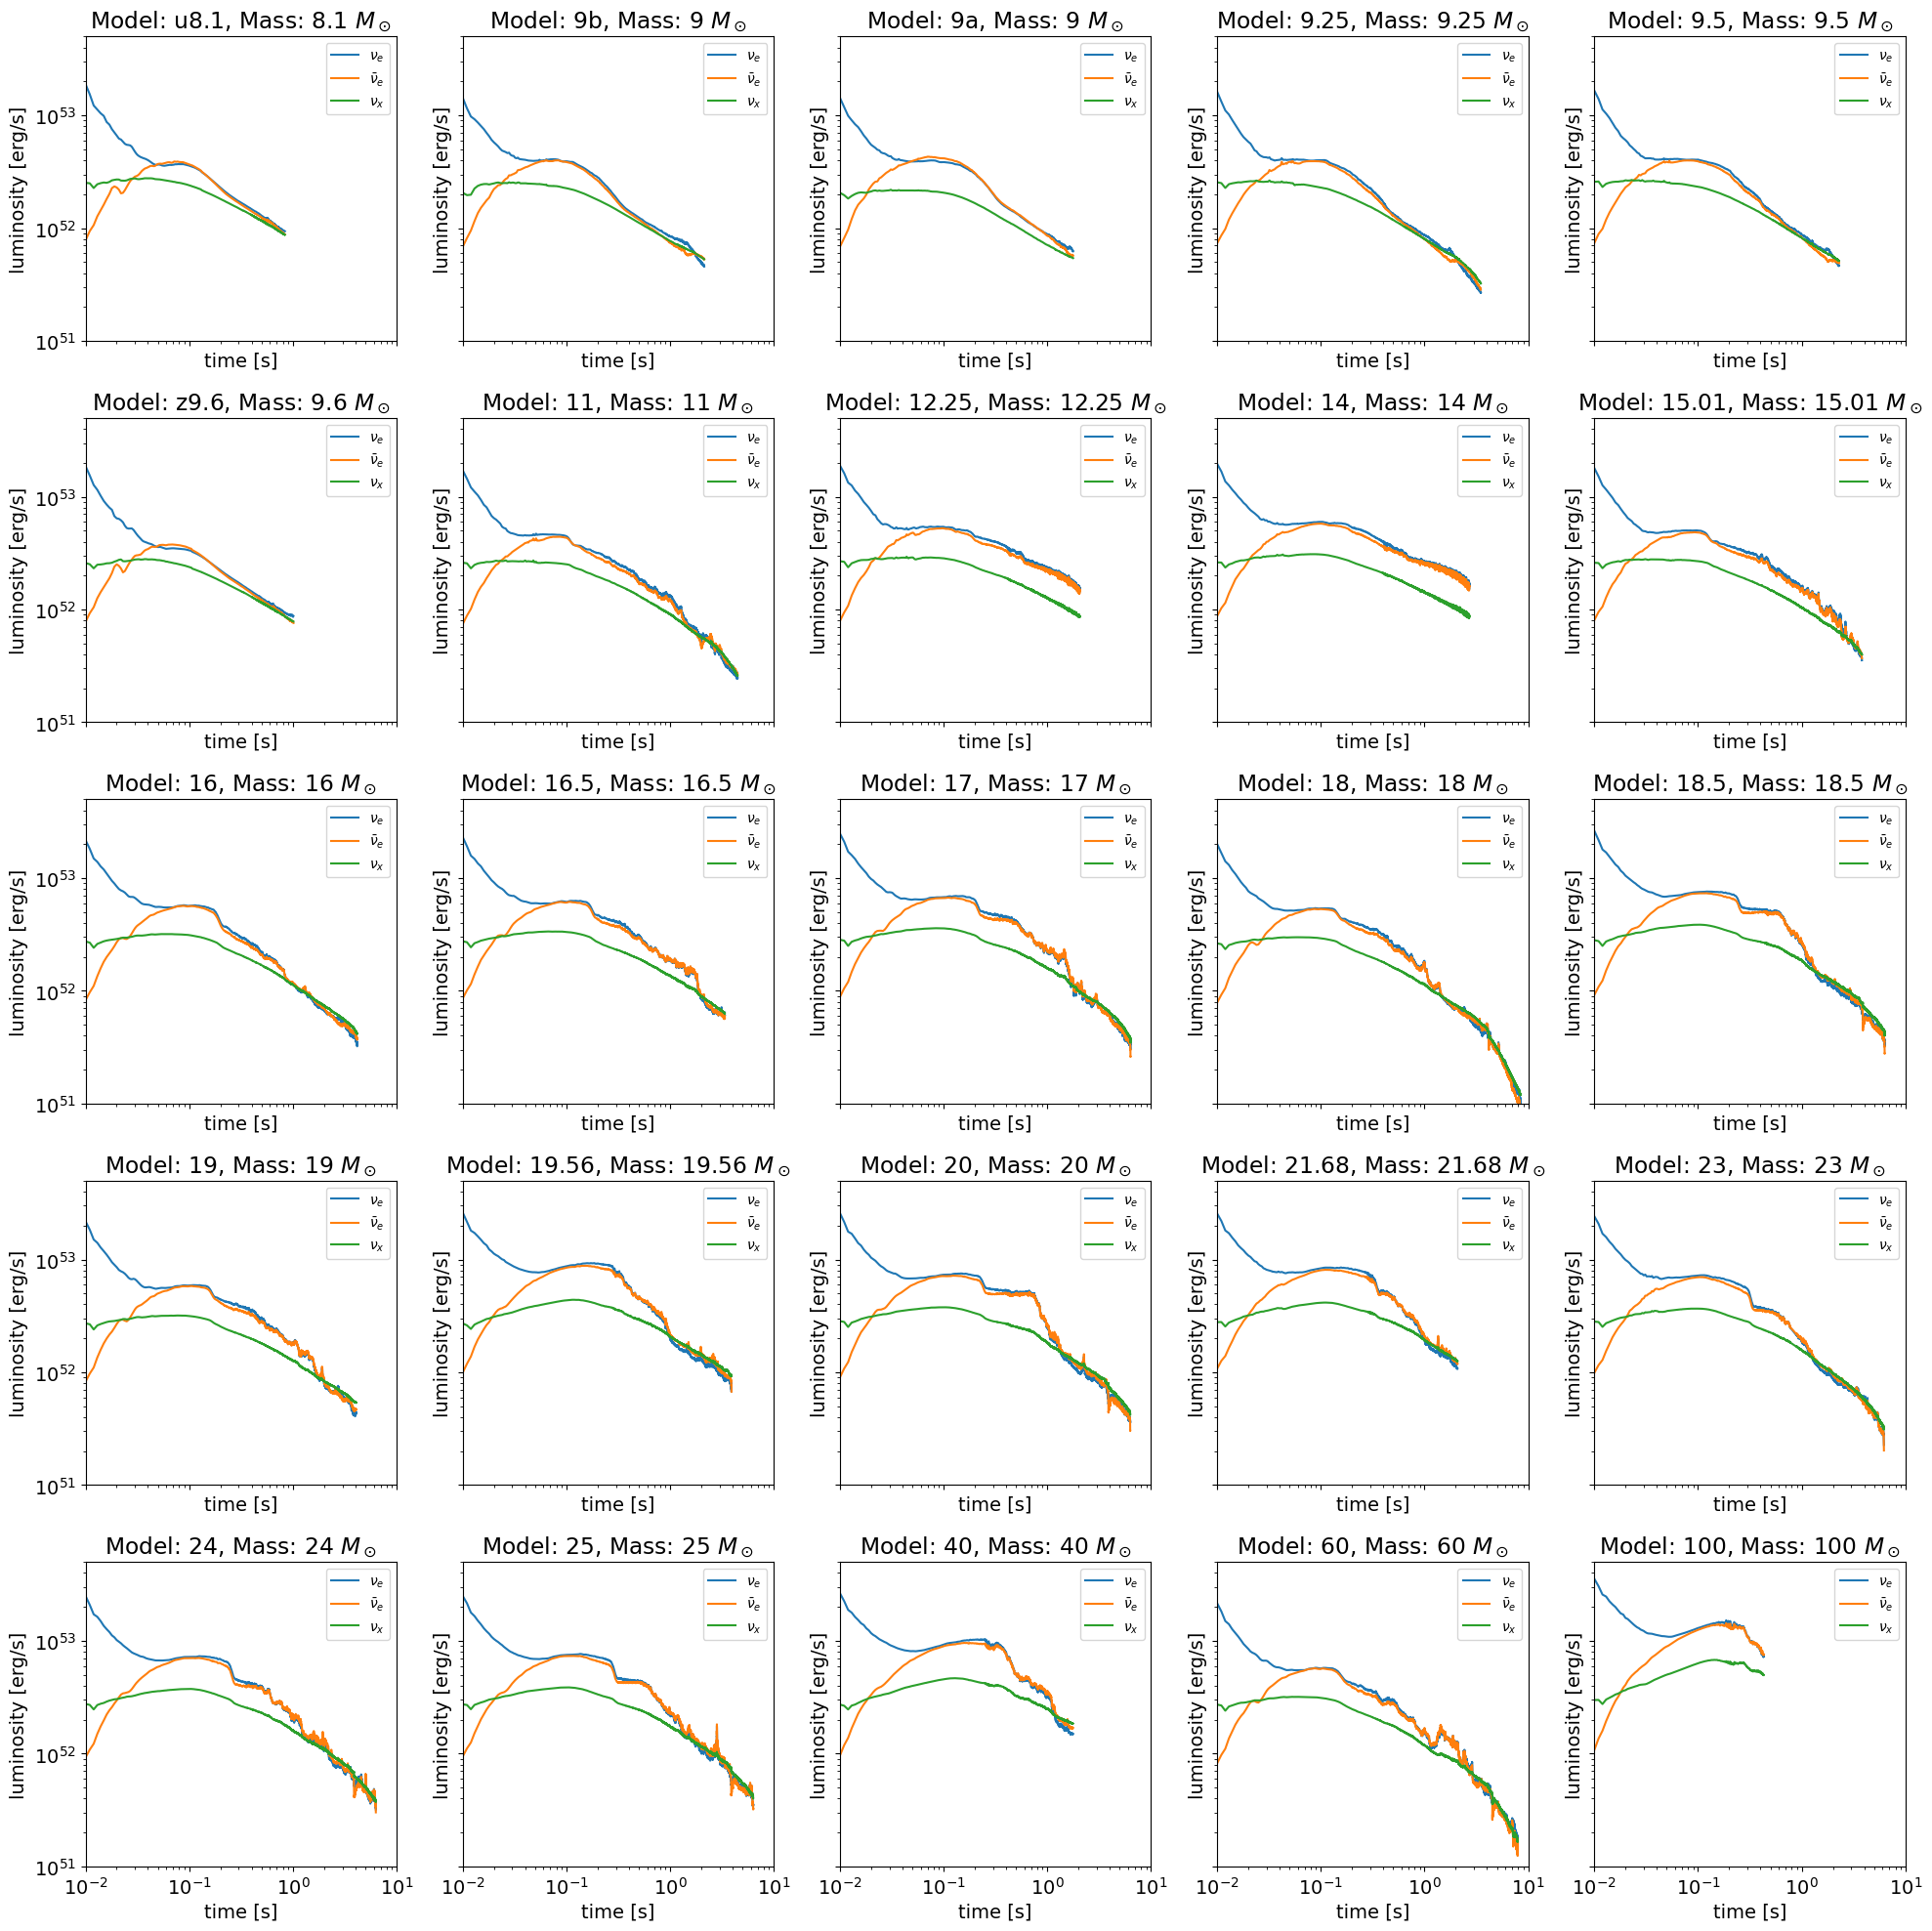

In [10]:
#- Loop over all models in order of progenitor mass
labels = [r'$\nu_e$', r'$\bar{\nu}_e$', r'$\nu_x$']

fig, axes = plt.subplots(5, 5, figsize=(20,20), tight_layout=True, sharex=True, sharey=True)
axes = axes.flatten()
i = 0

for mass in sorted(models):
    for model in models[mass]:
        ax = axes[i]

        for j in range(3):
            datafile = f'{model}/nustat.{j}.dat'
            tab = Table.read(datafile, format='ascii')

            if j < 2:
                ax.plot(tab['1:time'], 1e75*tab['2:Lum'], label=labels[j % 3])
            else:
                ax.plot(tab['1:time'], 1e75/4*tab['2:Lum'], label=labels[j % 3])

        ax.legend(loc='upper right', fontsize=10)
        ax.set(xlabel='time [s]',
               xscale='log',
               xlim=(1e-2, 10),
               ylabel='luminosity [erg/s]',
               yscale='log',
               ylim=(1e51, 5e53),
               title=rf'Model: {model}, Mass: {mass:g} $M_\odot$')

        i += 1